In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

# Dask start

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34387")

# Import

In [4]:
import sys
sys.path.insert(1, '..')

In [5]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
#import xrft_module
import xesmf as xe

# Plotting params

In [77]:
#%matplotlib widget
%matplotlib inline

In [7]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [8]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys']

# Useful functions for histograms

In [9]:
def compute_1D_histogram(dataSet, var1, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
    else :
        bins1 = bins
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), bins=bins1, weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [93]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None, normalize=False) :
    if normalize :
        variable1_to_use = (dataSet[var1]-dataSet[var1].mean())#/dataSet[var1].std()
        variable2_to_use = (dataSet[var2]-dataSet[var2].mean())#/dataSet[var2].std()
    else :
        variable1_to_use = dataSet[var1]
        variable2_to_use = dataSet[var2]   
    if bins is None :
        bins1 = np.linspace(variable1_to_use.min(), variable1_to_use.max(), nb_of_bins)
        bins2 = np.linspace(variable2_to_use.min(), variable2_to_use.max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(variable1_to_use.fillna(0), variable2_to_use.fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [82]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

## Distance between histograms

- Kullback-Leibler (KL) divergence (or relative entropy) 
$$ D_{KL} (P || Q) = \sum_i P(i) \log\frac{P(i)}{Q(i)} $$
a measure of how one probability distribution $Q$ is different from a second, reference probability distribution $P$ (information gain of $P$ in comparison to $Q$). In other words, it is the amount of information lost when $Q$ is used to approximate $P$.

In [10]:
def D_KL(hist_P, hist_Q) :
    masked_P = np.where(hist_P >0, hist_P, np.NaN)
    masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    return np.nansum(masked_P*(np.log(masked_P/masked_Q)))

- Symmertrized KL divergence (Jeffreys divergence):
$$ D_{sym} (P || Q) = D_{KL} (P || Q) + D_{KL} (Q || P) $$

In [11]:
def D_sym(hist_P, hist_Q) :
    return D_KL(hist_P, hist_Q)+D_KL(hist_Q, hist_P)

- Difference between the KL divergences with opposite reference distributions:
$$ \Delta D_{KL} (P || Q) = D_{KL} (P || Q) - D_{KL} (Q || P) $$

In [12]:
def D_dif(hist_P, hist_Q) :
    return (D_KL(hist_P, hist_Q)-D_KL(hist_Q, hist_P))

# Load data

Choose cases

In [13]:
data=[dict() for i in range(6)]

In [14]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES FMA'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES ASO'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

## eNATL60

In [15]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [16]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,150),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [17]:
nb_of_time_chunks = 4

In [18]:
%%time
for i in range(len(data)) :
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set
    data[i]['HR'].attrs['source'] = 'eNATL60'

CPU times: user 3.01 s, sys: 631 ms, total: 3.64 s
Wall time: 1min 21s


## eORCA025

In [19]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("../Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).rename(nav_lat='lat', nav_lon='lon')
    data[i]['LR'].attrs['source'] = 'eORCA025'

# Filters

## Routines

In [21]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=window_size, y=window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=window_size, y=window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    new_e2t = data['e2t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binarize and erode the mask (to remove isolated pixels)
    threshold = 0.0
    new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
    result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
    #apply new mask to data
    result = result.where(result.tmask>0)
    return result

In [22]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    data = dataHR.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    wet_mask = xr.DataArray(data.tmask, dims=['y','x'])
    area = xr.DataArray((data.e1t * data.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(data.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(data.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(data.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(data.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=data.coords)
        data_filtered = gaussian_filter.apply(data, dims=['y', 'x'])
    else :
        data_filtered =  xr.Dataset({}, coords=data.coords)
        data_filtered = data
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Set of filters to compare

In [36]:
coarsening_window_size = 15
filters = [dict({'filter_coef' : 0, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Coarse to 0.25°'}),
          dict({'filter_coef' : 7.5, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Filter 0.125° + Coarse to 0.25°'}),
          dict({'filter_coef' : 15, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Filter 0.25° + Coarse to 0.25°'}),
          dict({'filter_coef' : 30, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Filter 0.5° + Coarse to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 2*coarsening_window_size, 'interpolate' : True, 'label' : 'Coarse to 0.5° + Interp to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 4*coarsening_window_size, 'interpolate' : True, 'label' : 'Coarse to 1° + Interp to 0.25°'})]

In [37]:
regrid_method = 'bilinear'

In [38]:
%%time
%%capture --no-display
for i in range(len(data)) : 
    data[i]['HR_Filtered'] = [] 
    ref_data = data[i]['LR']
    out_grid = xr.DataArray(coords={'lon' : ref_data.lon, 'lat' : ref_data.lat, 'x': ref_data.x, 'y': ref_data.y}, dims=['y', 'x'])
    for ifilter, curr_filter in enumerate(filters) :
        filtered = apply_filter_downsample(data[i]['HR'], curr_filter['filter_coef'], curr_filter['coarsening_window_size']).compute().\
                                                               chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
        if (curr_filter['interpolate']):
            regridder = xe.Regridder(filtered, out_grid, regrid_method, unmapped_to_nan=True)
            regridded = regridder(filtered)
            regridded.coords['e1t'] = ref_data.e1t
            regridded.coords['e2t'] = ref_data.e2t
            data[i]['HR_Filtered'].append(regridded)
        else :
            data[i]['HR_Filtered'].append(filtered)

CPU times: user 57.2 s, sys: 10.8 s, total: 1min 8s
Wall time: 6min 53s


# Statistics of the finite differences

Finite-difference evaluation of squares of the local gradients:
$$ \Delta_x T(x,y)\equiv \frac{1}{2} \left[\overline{T}(x+\Delta x, y) - \overline{T}(x - \Delta x, y)\right] $$
$$ \Delta_y T(x,y)\equiv \frac{1}{2} \left[\overline{T}(x, y+\Delta y) - \overline{T}(x, y- \Delta y)\right] $$
$$ |\delta x \cdot \nabla \overline{T}|^2 (x,y) \equiv [\Delta_x T(x,y)]^2 + [\Delta_y T(x,y)]^2 $$
and the same for salinity.

In [39]:
# def diffs_x(dataArray) :
#     return (dataArray.shift(x=-1) - dataArray)
# def diffs_y(dataArray) :
#     return (dataArray.shift(y=-1) - dataArray)
def central_diffs_x(dataArray) :
    return 0.5*(dataArray.shift(x=-1) - dataArray.shift(x=1))
def central_diffs_y(dataArray) :
    return 0.5*(dataArray.shift(y=-1) - dataArray.shift(y=1))

In [57]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds["diff_x_T"] = central_diffs_x(ds['sosstsst'])
        ds["diff_y_T"] = central_diffs_y(ds['sosstsst'])
        ds["diff_x_S"] = central_diffs_x(ds['sosaline'])
        ds["diff_y_S"] = central_diffs_y(ds['sosaline'])
        ds["diff_T_sqr"] = ds["diff_x_T"]**2 + ds["diff_y_T"]**2
        ds["diff_S_sqr"] = ds["diff_x_S"]**2 + ds["diff_y_S"]**2

CPU times: user 3.02 s, sys: 9.64 ms, total: 3.03 s
Wall time: 3.02 s


## Snapshots

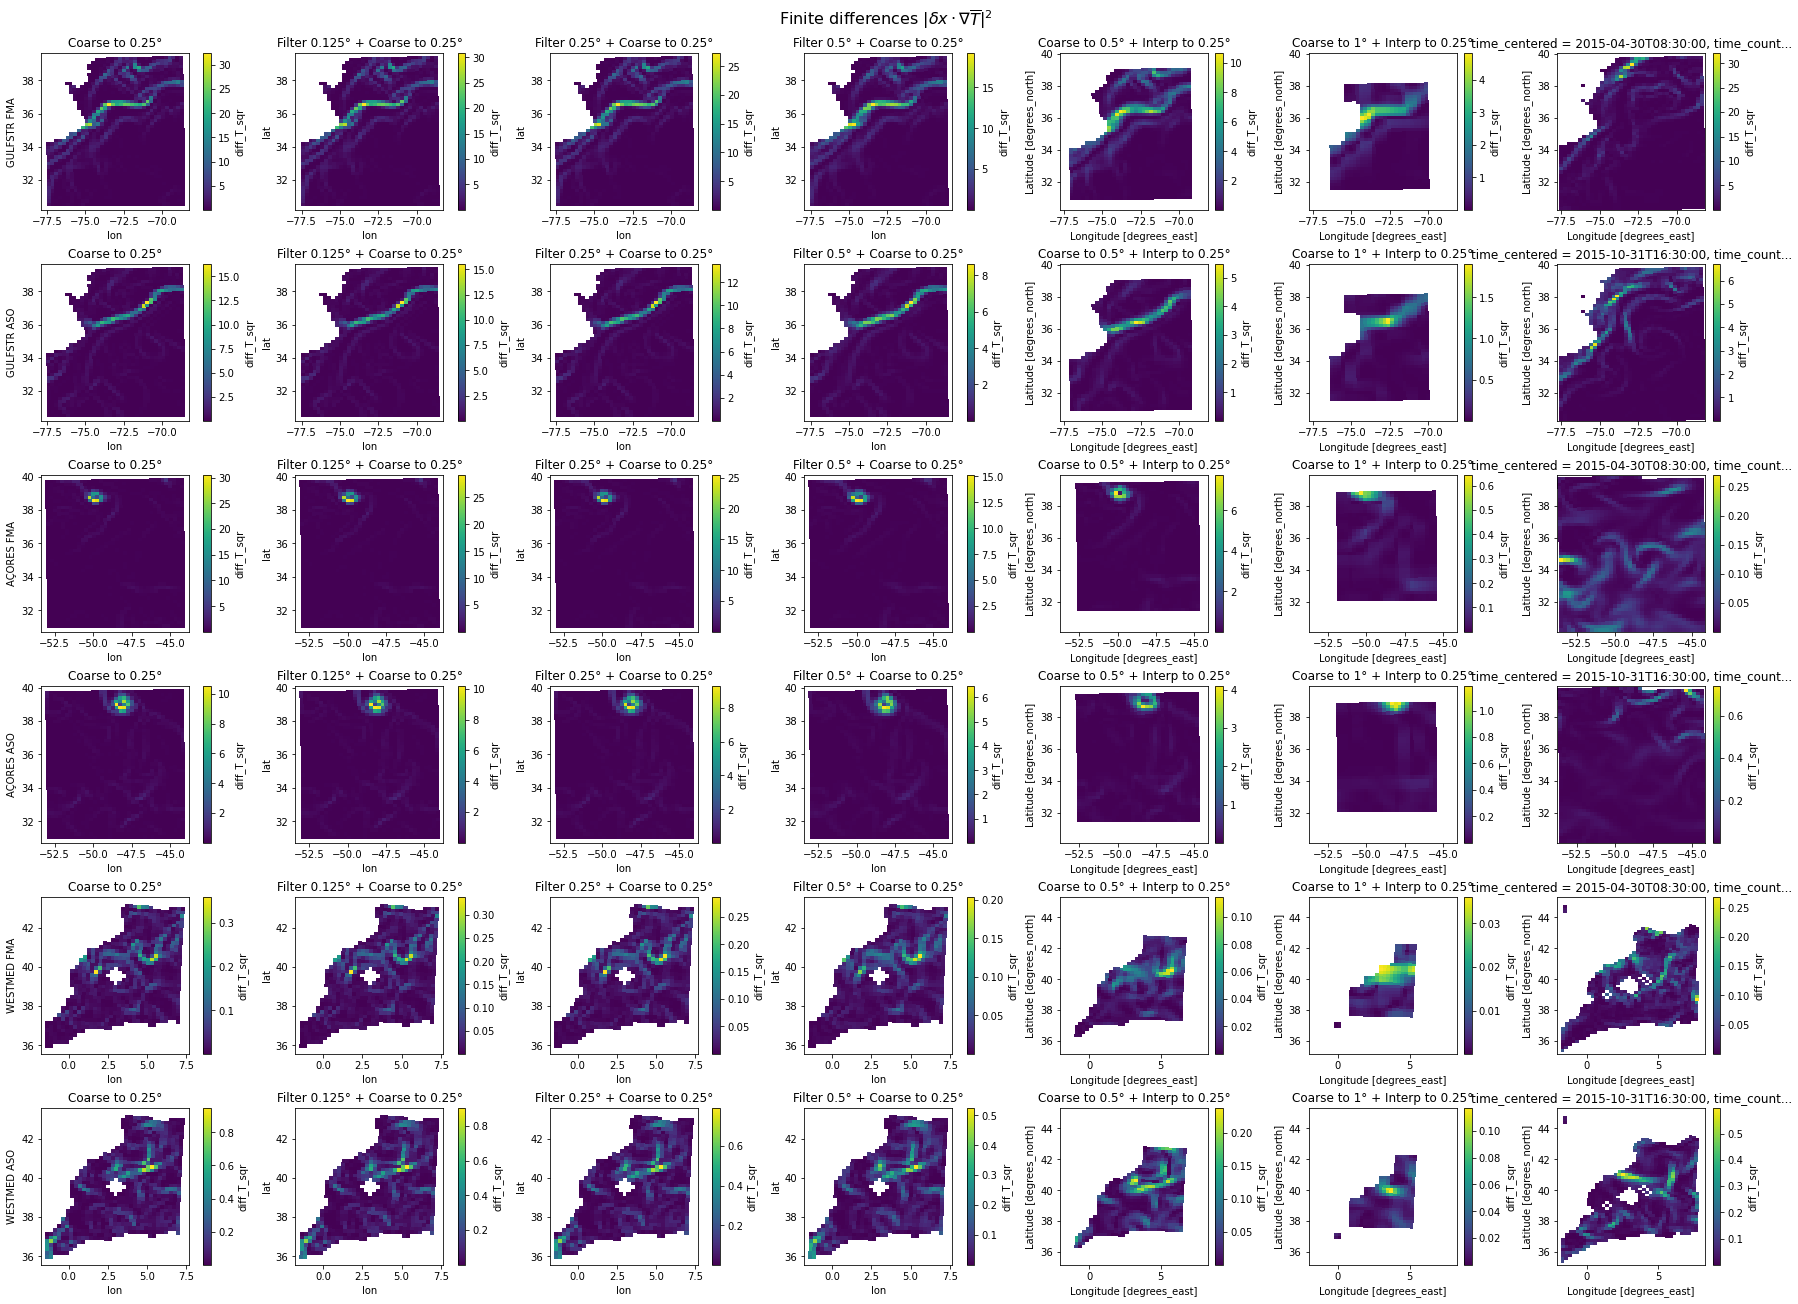

In [58]:
ncols = len(filters)+1
nrows=len(data)
fig, axis = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3.5*ncols,3*nrows), constrained_layout=True)
quantity='diff_T_sqr'
fig.suptitle(r'Finite differences $|\delta x \cdot \nabla \overline{T}|^2$', size=16)
for row in range(len(data)) :
    for ifilter in range(len(filters)) :
        col = ifilter
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity][bord_cut].plot(x='lon', y='lat', ax=axis[row,col], cmap='viridis')
        axis[row,col].set(title=filters[ifilter]['label'])   
    data[row]['LR'].isel(time_counter=-1)[quantity][bord_cut].plot(x='lon', y='lat', ax=axis[row,-1], cmap='viridis')
    axis[row,0].set(ylabel=data[row]['label'])

## 2D histograms

In [94]:
x_slice = slice(1,-1)
y_slice = slice(1,-1)
bord_cut = dict(y=y_slice,x=x_slice) # to cut borders 

In [95]:
nb_of_bins = 150

In [96]:
# initialize data structure for storing histograms
hists=[dict() for i in range(len(data))]
for i in range(len(data)) :
    hists[i]['HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists[i]['HR'] = dict({'label' : 'eNATL60'})
    hists[i]['LR'] = dict({'label' : 'eORCA025'})

### Temperature

In [97]:
%%time
name_hist = 'hist_temp_diff_2D'
x = 'diff_x_T'
y = 'diff_y_T'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['HR_Filtered'][ref_case], x, y, nb_of_bins, normalize=True).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins, normalize=True).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter], x, y, nb_of_bins, bins=bins, normalize=True).compute()

CPU times: user 3.64 s, sys: 112 ms, total: 3.75 s
Wall time: 15.7 s


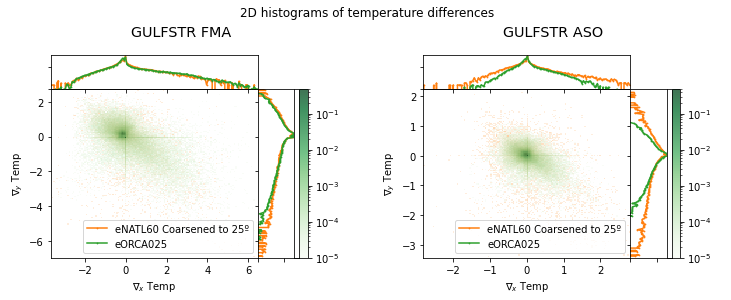

In [98]:
name_hist = 'hist_temp_diff_2D'
x = 'diff_x_T_bin'
y = 'diff_y_T_bin'

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
fig.suptitle('2D histograms of temperature differences')
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for subfig_index, region in enumerate([0,1]) :
    subfigs[subfig_index].suptitle(data[region]['label'], fontsize='x-large')
    sel_data1 = hists[region]['HR_Filtered'][0][name_hist]
    sel_data2 = hists[region]['LR'][name_hist]
    big_ax = subfigs[subfig_index].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[subfig_index].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[subfig_index].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[subfig_index].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data1, 1, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 2, x, y, top_ax, right_ax, big_ax)
    big_ax.set(xlabel=r'$\nabla_x$ Temp', ylabel=r'$\nabla_y$ Temp')
    big_ax.legend(handles=top_ax.lines, labels=['eNATL60 Coarsened to 25º','eORCA025'], loc='lower right')

    subfigs[subfig_index].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

### Salinity

In [99]:
%%time
name_hist = 'hist_sal_diff_2D'
x = 'diff_x_S'
y = 'diff_y_S'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['HR_Filtered'][ref_case], x, y, nb_of_bins, normalize=True).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins, normalize=True).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter], x, y, nb_of_bins, bins=bins, normalize=True).compute()

CPU times: user 3.74 s, sys: 110 ms, total: 3.85 s
Wall time: 16.2 s


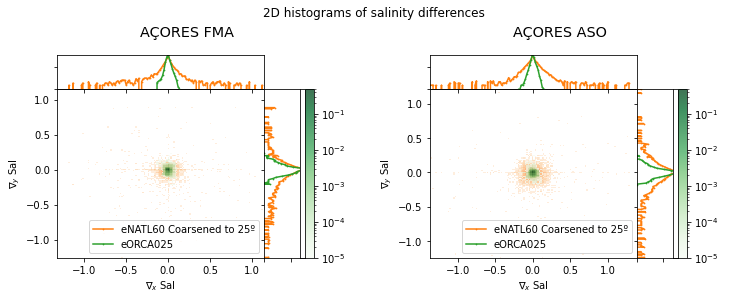

In [100]:
name_hist = 'hist_sal_diff_2D'
x = 'diff_x_S_bin'
y = 'diff_y_S_bin'

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
fig.suptitle('2D histograms of salinity differences')
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for subfig_index, region in enumerate([2,3]) :
    subfigs[subfig_index].suptitle(data[region]['label'], fontsize='x-large')
    sel_data1 = hists[region]['HR_Filtered'][0][name_hist]
    sel_data2 = hists[region]['LR'][name_hist]
    big_ax = subfigs[subfig_index].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[subfig_index].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[subfig_index].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[subfig_index].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data1, 1, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 2, x, y, top_ax, right_ax, big_ax)
    big_ax.set(xlabel=r'$\nabla_x$ Sal', ylabel=r'$\nabla_y$ Sal')
    big_ax.legend(handles=top_ax.lines, labels=['eNATL60 Coarsened to 25º','eORCA025'], loc='lower right')

    subfigs[subfig_index].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

### KL divergence

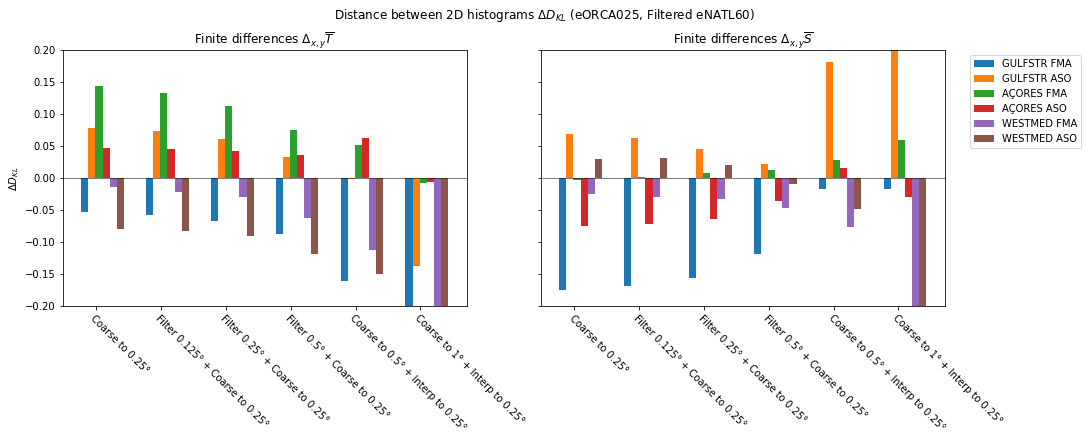

CPU times: user 2.01 s, sys: 570 ms, total: 2.58 s
Wall time: 1.6 s


In [105]:
%%time
fig, axis = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 6), sharey=True)
fig.suptitle('Distance between 2D histograms $\Delta D_{KL}$ (eORCA025, Filtered eNATL60)')
x = np.arange(len(filters))
bar_width = 0.11
for i_dataset in range(len(data)) :
    axis[0].bar(x+(i_dataset)*bar_width, [D_dif(hists[i_dataset]['LR']['hist_temp_diff_2D'], hists[i_dataset]['HR_Filtered'][ifilter]['hist_temp_diff_2D']) \
                                          for ifilter in range(len(filters))], width=bar_width)
    axis[1].bar(x+(i_dataset)*bar_width, [D_dif(hists[i_dataset]['LR']['hist_sal_diff_2D'], hists[i_dataset]['HR_Filtered'][ifilter]['hist_sal_diff_2D']) \
                                          for ifilter in range(len(filters))], width=bar_width, label=data[i_dataset]['label'])
for ax in axis :
    ax.set_xticks(x + 1.6*bar_width)
    ax.set_xticklabels([filt['label'] for filt in filters],fontsize=10,rotation = -45,ha="left", rotation_mode="anchor")
    ax.set(yscale='linear')
    ax.axhline(y=0., color='k', lw=0.5)
    ax.set(ylim=[-0.2,0.2])
axis[0].set(title=r'Finite differences $\Delta_{x,y} \overline{T}$', ylabel=r'$\Delta D_{KL}$')
axis[1].set(title=r'Finite differences $\Delta_{x,y} \overline{S}$')
axis[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 1D histograms

In [112]:
%%time
normalized = False
for variable in ["diff_T_sqr", "diff_S_sqr"] :
    for i in range(len(data)) :
        # reference histogram (to make same bins for all histograms - better for comparison)
        ref_histo = compute_1D_histogram(data[i]['HR_Filtered'][0][bord_cut], variable, nb_of_bins, bins=None).compute()
        ref_bins = ref_histo[variable+'_bin'].values

        hists[i]['LR'][variable] = compute_1D_histogram(data[i]['LR'][bord_cut], variable, nb_of_bins, bins=ref_bins).compute()
        for ifilter in range(len(filters)) :
            hists[i]['HR_Filtered'][ifilter][variable] = compute_1D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], variable, nb_of_bins, bins=ref_bins)

CPU times: user 4.82 s, sys: 134 ms, total: 4.96 s
Wall time: 15.8 s


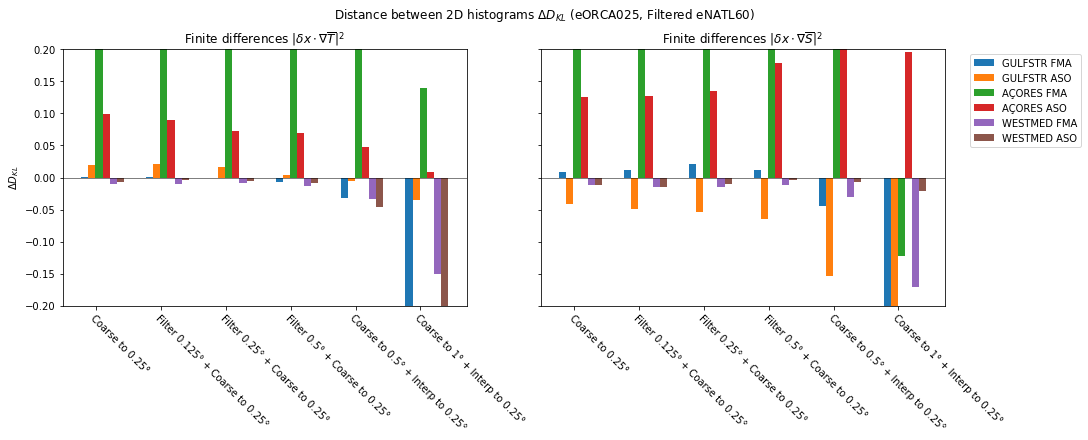

CPU times: user 6.89 s, sys: 445 ms, total: 7.34 s
Wall time: 41 s


In [114]:
%%time
fig, axis = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 6), sharey=True)
fig.suptitle('Distance between 2D histograms $\Delta D_{KL}$ (eORCA025, Filtered eNATL60)')
x = np.arange(len(filters))
bar_width = 0.11
for i_dataset in range(len(data)) :
    axis[0].bar(x+(i_dataset)*bar_width, [D_dif(hists[i_dataset]['LR']['diff_T_sqr'], hists[i_dataset]['HR_Filtered'][ifilter]['diff_T_sqr']) \
                                          for ifilter in range(len(filters))], width=bar_width)
    axis[1].bar(x+(i_dataset)*bar_width, [D_dif(hists[i_dataset]['LR']['diff_S_sqr'], hists[i_dataset]['HR_Filtered'][ifilter]['diff_S_sqr']) \
                                          for ifilter in range(len(filters))], width=bar_width, label=data[i_dataset]['label'])
for ax in axis :
    ax.set_xticks(x + 1.6*bar_width)
    ax.set_xticklabels([filt['label'] for filt in filters],fontsize=10,rotation = -45,ha="left", rotation_mode="anchor")
    ax.set(yscale='linear')
    ax.axhline(y=0., color='k', lw=0.5)
    ax.set(ylim=[-0.2,0.2])
axis[0].set(title=r'Finite differences $|\delta x \cdot \nabla \overline{T}|^2$', ylabel=r'$\Delta D_{KL}$')
axis[1].set(title=r'Finite differences $|\delta x \cdot \nabla \overline{S}|^2$')
axis[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Mixed 2d histogram

In [115]:
%%time
name_hist = 'hist_mixed_diff_2D'
x = 'diff_T_sqr'
y = 'diff_S_sqr'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['HR_Filtered'][ref_case], x, y, nb_of_bins, normalize=True).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins, normalize=True).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter], x, y, nb_of_bins, bins=bins, normalize=True).compute()

CPU times: user 4.23 s, sys: 149 ms, total: 4.38 s
Wall time: 19.1 s


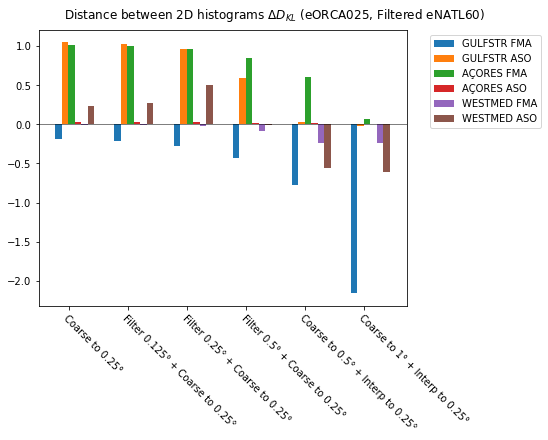

CPU times: user 497 ms, sys: 187 ms, total: 684 ms
Wall time: 362 ms


In [121]:
%%time
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(7.5, 6), sharey=True)
fig.suptitle('Distance between 2D histograms $\Delta D_{KL}$ (eORCA025, Filtered eNATL60)')
x = np.arange(len(filters))
bar_width = 0.11
for i_dataset in range(len(data)) :
    ax.bar(x+(i_dataset)*bar_width, [D_dif(hists[i_dataset]['LR']['hist_mixed_diff_2D'], hists[i_dataset]['HR_Filtered'][ifilter]['hist_mixed_diff_2D']) \
                                          for ifilter in range(len(filters))], width=bar_width, label=data[i_dataset]['label'])

ax.set_xticks(x + 1.6*bar_width)
ax.set_xticklabels([filt['label'] for filt in filters],fontsize=10,rotation = -45,ha="left", rotation_mode="anchor")
ax.set(yscale='linear')
ax.axhline(y=0., color='k', lw=0.5)
#ax.set(ylim=[-1.2,0.2])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Interpretation

## Quantities used to compare eORCA025 with filtered eNATL60

The squares of finite differences $|\delta \textbf{x} \cdot \nabla \overline{T}|^2$ and $|\delta \textbf{x} \cdot \nabla \overline{S}|^2$ are good candidates for statistical testing of the spatial filtering procedures because:
- They are used as predictors for subgrid variance in previous studies.
If we are capable to 
- They are sensitive to "smoothness" of the fields and to the choice of the filter
- Easy to extract

## Use difference between KL divergences as metrics

- Kullback-Leibler (KL) divergence (or relative entropy)  is defined as:
$$ D_{KL} (P || Q) = \sum_i P(i) \log\frac{P(i)}{Q(i)} $$
It measures how one probability distribution $Q$ is different from a second, reference probability distribution $P$ (information gain of $P$ in comparison to $Q$). In other words, it is the amount of information lost when $Q$ is used to approximate $P$.
Therefore, if we try to check the difference between divergences with swapped reference distributions:
$$ \Delta D_{KL} (P || Q) = D_{KL} (P || Q) - D_{KL} (Q || P) $$
the value of $ \Delta D_{KL} $ can tell us something about relative information contain in distributions $P$ and $Q$, in particular:
- if $ \Delta D_{KL} \approx 0 $ the two distributions have more or less the same information, the divergence is small and it does not matter which distribution to use as the reference. This would be an ideal filtering.
- if $ \Delta D_{KL} < 0 $ the information content of the distribution $P$ is <b>larger</b>. If we put eORCA025 distributions as the reference $P$ this case would correspond to the situation when ORCA025 data contains larger varienty of gradients than the filtered eNATL60 data. This case would correspond to <i> overfiltering </i>, and it should be avoided.
- if $ \Delta D_{KL} > 0 $ the reference distribution $P$ contains less information. In other words, the filtered fields still contain some features from HR data, not represented in eORCA025 data. This case would correspond to <i> underfiltering </i>, but this situation is acceptable, because the most important is that the filtered data contains the small-scale features that can appear in ORCA025. If it contains some more events, like stronger gradients, not represented in ORCA025, it should not be an issue, since the parametrization will adapt to weaker gradients.

The main idea is to find such a filter that would not allow overfiltering in none of the data sets (in all regions and seasons). At the same time, the situation with underfiltering should be consitered as acceptable.